In [1]:
# Uncomment to use autoreload
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import torch
import numpy as np
from time import time
from omegaconf import OmegaConf
start = time()
import warnings
warnings.filterwarnings('ignore')

# torch.cuda.set_device(I_GPU)
DIR = os.path.dirname(os.getcwd())
ROOT = os.path.join(DIR, "..")
sys.path.insert(0, ROOT)
sys.path.insert(0, DIR)

from torch_points3d.utils.config import hydra_read
from torch_geometric.data import Data
from torch_points3d.core.multimodal.data import MMData, MMBatch
from torch_points3d.visualization.multimodal_data import visualize_mm_data
from torch_points3d.core.multimodal.image import SameSettingImageData, ImageData
from torch_points3d.datasets.segmentation.multimodal.scannet import ScannetDatasetMM
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS
from torch_points3d.metrics.segmentation_tracker import SegmentationTracker
from torch_points3d.datasets.segmentation import IGNORE_LABEL
from torch_points3d.metrics.scannet_segmentation_tracker import ScannetSegmentationTracker
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq

from collections import defaultdict

from PIL import Image

import matplotlib.pyplot as plt 
# import seaborn as sns
# sns.set()

%matplotlib inline

CLASS_COLORS[0] = (174.0, 199.0, 232.0)
CLASS_COLORS[-1] = (0, 0, 0)
import plotly.io as pio

#pio.renderers.default = 'jupyterlab'        # for local notebook
pio.renderers.default = 'iframe_connected'  # for remote notebook. Other working (but seemingly slower) options are: 'sphinx_gallery' and 'iframe'

import os
import os.path as osp
import copy
import torch
import hydra
import logging
import scipy.ndimage
import numpy as np
from PIL import Image
import open3d as o3d

# Import building function for model and dataset
from torch_points3d.datasets.dataset_factory import instantiate_dataset
from torch_points3d.models.model_factory import instantiate_model

# Import BaseModel / BaseDataset for type checking
from torch_points3d.models.base_model import BaseModel
from torch_points3d.datasets.base_dataset import BaseDataset

# Import from metrics
from torch_points3d.metrics.base_tracker import BaseTracker
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq
from torch_points3d.metrics.model_checkpoint import ModelCheckpoint

# Utils import
from torch_points3d.utils.colors import COLORS
from torch_points3d.utils.wandb_utils import Wandb
from torch_points3d.utils.config import getattr_recursive
from torch_points3d.visualization import Visualizer
from torch_points3d.core.data_transform.transforms import PointcloudMerge
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS


log = logging.getLogger(__name__)

def get_seen_points(mm_data):
    ### Select seen points
    csr_idx = mm_data.modalities['image'][0].view_csr_indexing
    dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
    # take subset of only seen points without re-indexing the same point
    mm_data = mm_data[dense_idx_list.unique()]
    return mm_data

def get_mode_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    mode_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
    mode_preds = torch.stack(mode_preds, dim=0)
        
    return mode_preds

def get_random_view_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    selected_view_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        selected_idx = torch.randint(low=0, high=m2feats_of_seen_point.shape[0], size=(1,))
        selected_pred = m2feats_of_seen_point[selected_idx].squeeze(0)
        selected_view_preds.append(selected_pred)
    selected_view_preds = torch.stack(selected_view_preds, dim=0)
        
    return selected_view_preds




[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
MMData debug() function changed, please uncomment the 3rd assert line when doing inference without M2F features!
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# # model_name = 'MVFusion_small_6views' # fixed, problem was casting the pixel_validity mask to .long()

# # model_name = 'MVFusion_orig' # good

# # model_name = 'MVFusion_somehow_works' # good

# # model_name = 'MVFusion_3D_small_6views' # good
# # model_name = 'MVFusion_3D_small'


# ###################################################################
# if model_name == 'MVFusion_3D_small_6views' :
#     checkpoint_dir = ["/home/fsun/DeepViewAgg/outputs/MVFusion_3D_6_views_m2f_masks",
#                       "/home/fsun/DeepViewAgg/outputs/ViT_masks_3rd_run"]
#     models_config = 'segmentation/multimodal/Feng/mvfusion' 
# elif model_name == 'Deepset_3D':
#     checkpoint_dir = ["/home/fsun/DeepViewAgg/outputs/2023-02-05/23-15-04",
#                       "/home/fsun/DeepViewAgg/outputs/2023-01-23/12-57-16"]        
#     models_config = 'segmentation/multimodal/Feng/view_selection_experiment' 
# elif model_name == 'MVFusion_orig':
#     checkpoint_dir = ['/home/fsun/DeepViewAgg_31-10-22/DeepViewAgg/outputs/2023-02-11/22-17-12',
#                       '/home/fsun/DeepViewAgg/outputs/MVFusion_orig']
#     models_config = 'segmentation/multimodal/Feng/mvfusion_orig' 
# elif model_name == 'DeepSetAttention':
#     checkpoint_dir = ['/home/fsun/DeepViewAgg/outputs/2023-02-11/10-54-19',
#                       '/home/fsun/DeepViewAgg/outputs/2023-02-11/10-52-09']   # old: 'DeepSet_feats_labels_superconvergence'
#     models_config = 'segmentation/multimodal/Feng/view_selection_experiment' 
    
    
# elif model_name == 'MVFusion_small_6views':
#     models_config = 'segmentation/multimodal/Feng/view_selection_experiment' 
    
# elif model_name == 'MVFusion_somehow_works':
#     models_config = 'segmentation/multimodal/Feng/mvfusion_orig' 
    
# elif model_name == 'MVFusion_3D_small':
#     models_config = 'segmentation/multimodal/Feng/mvfusion' 



In [3]:
# Set your dataset root directory, where the data was/will be downloaded
DATA_ROOT = '/scratch-shared/fsun/dvata'

dataset_config = 'segmentation/multimodal/Feng/scannet-superconvergence-adamw.yaml'   


# dataset_config = 'segmentation/multimodal/Feng/scannet-val-val.yaml'   
# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f.yaml'   
# models_config = 'segmentation/multimodal/Feng/mvfusion'    # model family
# model_name = 'MVFusion_3D_small_6views_view_fusion_loss'                       # specific model


# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f.yaml'   
# models_config = 'segmentation/multimodal/Feng/view_selection_experiment' 
# model_name = 'DeepSetAttention'

# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f.yaml'   
models_config = 'segmentation/multimodal/Feng/view_selection_experiment' 
model_name = 'MVFusion_small_6views'


overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'models={models_config}',
    f'model_name={model_name}',
    f'data.dataroot={DATA_ROOT}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
cfg.data.load_m2f_masks = True   # load Mask2Former predicted masks
cfg.data.m2f_preds_dirname = 'ViT_masks'
cfg.data.n_views = cfg.models[model_name].backbone.transformer.n_views
print("n_views: ", cfg.data.n_views)

# Dataset instantiation
start = time()
dataset = ScannetDatasetMM(cfg.data)
# print(dataset)|
print(f"Time = {time() - start:0.1f} sec.")

n_views:  6
Load predicted 2D semantic segmentation labels from directory  ViT_masks
initialize train dataset
initialize val dataset
Time = 12.7 sec.


In [15]:
d = dataset.val_dataset[0]
d

tensor([[-0.6952],
        [-0.6953],
        [-0.6953],
        ...,
        [ 1.8945],
        [ 1.8882],
        [ 1.8881]])


MMData(
    data = Data(coords=[97387, 3], grid_size=[1], id_scan=[1], mapping_index=[97387], mvfusion_input=[71302, 6, 10], origin_id=[97387], pos=[97387, 3], rgb=[97387, 3], x=[97387, 1], y=[97387])
    image = ImageData(num_settings=1, num_views=100, num_points=97387, device=cpu)
)

In [5]:
# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)
print(model)

# # Load the checkpoint and recover the 'best_miou' model weights
# checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
# model.load_state_dict_with_same_shape(checkpoint['models']['best_miou'], strict=False)

# Prepare the model for training
model = model.cuda()
print('Model loaded')


Creating model: MVFusion_small_6views
task:  segmentation.multimodal
tested_model_name:  MVFusion_small_6views
class_name:  MVFusion_model
model_module:  torch_points3d.models.segmentation.multimodal.Feng.mvfusion
name, cls of chosen model_cls:  MVFusion_model <class 'torch_points3d.models.segmentation.multimodal.Feng.mvfusion.MVFusion_model'>
opt:   {'class': 'Feng.mvfusion.MVFusion_model', 'down_conv': {'image': {'down_conv': {'module_name': 'ADE20KResNet18PPM', 'frozen': False}, 'atomic_pooling': {'module_name': 'BimodalCSRPool', 'mode': 'max'}, 'view_pooling': {'module_name': 'GroupBimodalCSRPool', 'in_map': 8, 'in_mod': 512, 'num_groups': 4, 'use_mod': False, 'gating': True, 'group_scaling': True, 'map_encoder': 'DeepSetFeat', 'use_num': True, 'pool': 'max', 'fusion': 'concatenation'}, 'fusion': {'module_name': 'BimodalFusion', 'mode': 'concatenation'}, 'drop_mod': 0.0, 'branching_index': 0}}, 'backbone': {'transformer': {'n_views': 6, 'in_map': 9, 'in_m2f': 20, 'embed_dim': 64, '

### Input data for quick hypothesis

In [5]:
# scan_dir = "/scratch-shared/fsun/data/scannet/scans"
# mapping_idx_to_scan_names = getattr(dataset.val_dataset, "MAPPING_IDX_TO_SCAN_{}_NAMES".format(dataset.val_dataset.split.upper()))
# val_scans = list(mapping_idx_to_scan_names.values())

# d = {}
# for scene_id in val_scans:
#     p = osp.join(scan_dir, scene_id, f'{scene_id}.txt')
#     with open(p, 'r') as f:
#         lines = f.readlines()
#         sceneType = lines[-1].split("=")[-1].strip()
#         d[scene_id] = sceneType

In [6]:
# for scene_type, count in list(zip(*np.unique(list(d.values()), return_counts=True))):
#     print(scene_type, count)

### Create a new dataset split using validation scenes

In [7]:
# import pandas as pd

# datas = defaultdict(lambda: [])
# count = defaultdict(lambda: 0)

# for scene_type in list(np.unique(list(d.values()))):
#     for k, v in d.items():
#         if v == scene_type:
#             idx = list(mapping_idx_to_scan_names.keys())[list(mapping_idx_to_scan_names.values()).index(k)]
#             count[k[:-3]] += 1
            
# for scene_type in list(np.unique(list(d.values()))):
#     for k, v in d.items():
#         if v == scene_type:
#             idx = list(mapping_idx_to_scan_names.keys())[list(mapping_idx_to_scan_names.values()).index(k)]
            
#             if k[-2:] == '00':
#                 datas['scene_id'].append(k[:-3])
#                 datas['loader_idx'].append(idx)
#                 datas['num_scans'].append(count[k[:-3]])
#                 datas['scene_type'].append(scene_type)            
            
# df = pd.DataFrame.from_dict(datas)
# df

In [8]:
# train_set = df.groupby("scene_type").sample(frac=0.66, random_state=2)
# val_set = pd.concat([df, train_set]).drop_duplicates(keep=False)


# (len(train_set), train_set.num_scans.sum()), (len(val_set), val_set.num_scans.sum())

In [9]:
# import shutil

# # Create new train/val split in "/scratch-shared/fsun/dvata/scannet-val-val-split"
# p = "/scratch-shared/fsun/dvata"

# dataset_name = 'scannet-val-val-split'

# dataset_p = osp.join(p, dataset_name)

# os.makedirs(dataset_p, exist_ok=True)

# processed_dir = osp.join(dataset_p, 'processed')
# raw_dir = osp.join(dataset_p, 'raw')
# for d in [processed_dir, raw_dir]:
#     os.makedirs(d, exist_ok=True)
    
# os.symlink("/scratch-shared/fsun/data/scannet/scans", osp.join(raw_dir, 'scans'))

# meta_dir = osp.join(raw_dir, 'metadata')

# if not os.path.exists(meta_dir):
#     shutil.copytree("/scratch-shared/fsun/dvata/scannet-neucon-smallres-partial-subsampled/raw/metadata", meta_dir)


In [10]:
# SOURCE_SPLIT = 'val'

# for split, df in zip(['train', 'val'], [train_set, val_set]):
#     # Get list of scan_ids
#     res = [[scene_id + f"_0{i}" for i in range(count)] for scene_id, count in zip(df.scene_id, df.num_scans)]
#     res = [item for sublist in res for item in sublist]
#     # Write scan_ids to train and val splits
#     with open(osp.join(meta_dir, f'scannetv2_{split}.txt'),'r+') as f:
#         f.seek(0)
#         for scan_id in res:
#             f.write(f"{scan_id}\n")
#         f.truncate()    
     
#     for data_modality in ['processed_2d', 'raw']:

#         source_dir = f"/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/processed/{data_modality}_{SOURCE_SPLIT}"
#         target_dir = osp.join(processed_dir, f'{data_modality}_{split}')


#         if not os.path.exists(target_dir):
#             os.makedirs(target_dir, exist_ok=True)
#             # Symlink already processed 2d and 3d data to new dataset 
#             for scan_id in res:
#                 os.symlink(osp.join(source_dir, f"{scan_id}.pt"), osp.join(target_dir, f"{scan_id}.pt"))






# Data visualization tools

### Modeling

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_type = "SPARSE"
        
    def backward(self):
        self.loss_seg.backward()


    @property
    def device(self):
        return next(self.parameters()).device
    
class Linear(BaseNetwork):
    def __init__(self, feat_indices, loss_func, num_views, num_classes, use_3d=False):
        super().__init__()
        
        self.feat_indices = feat_indices
        self.loss_fn = loss_func
        self.num_views = num_views
        self.num_classes = num_classes
        self.use_3d = use_3d
            
        # in_dim = n view feats + input label one hot
        feat_dim = len(self.feat_indices) * self.num_views + self.num_classes * self.num_views
        
        if self.use_3d:
            feat_dim += 3
        
        hidden_dim = 64
        self.fc1 = nn.Sequential(
            nn.Linear(feat_dim, hidden_dim),
#             nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
#             nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, self.num_classes)
        )
        
    def set_input(self, batch, device):
        self.input = get_seen_points(batch).to(device)
        self.labels = self.input.y.to(device)
        
    def forward(self, epoch=1):
        
        # Input data processing
        input_label = self.input.data.mvfusion_input[:, :, -1].long()
        input_label_one_hot = F.one_hot(input_label, num_classes=self.num_classes).flatten(1, 2)
        
        x = self.input.data.mvfusion_input[:, :, self.feat_indices].flatten(1, 2)
        
        if self.use_3d:
            data_3d = self.input.data.x
            x = torch.cat((data_3d, x, input_label_one_hot), axis=-1)
        else:
            x = torch.cat((x, input_label_one_hot), axis=-1)

        
        # Model forward
        out = self.fc1(x)
        
        # Loss and logits
        self.output = F.log_softmax(out, dim=-1)
        self.loss_seg = self.loss_fn(self.output, self.labels)


# Bottom-up approach to view-fusion problem

- Test simple neural networks and measure losses/metrics. 
- Gradually increase model complexity, while inspecting under/overfitting.

### LR finder

In [12]:
# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)
print(model)

# # Load the checkpoint and recover the 'best_miou' model weights
# checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
# model.load_state_dict_with_same_shape(checkpoint['models']['best_miou'], strict=False)

# Prepare the model for training
model = model.cuda()
print('Model loaded')


# Create train and validation loader
dataset.create_dataloaders(
    model,
    6,  # train bs
    True,  # shuffle
    17,
    False,
    train_only=True,
    val_only=False,
    test_batch_size=1
)    

Creating model: MVFusion_small_6views
task:  segmentation.multimodal
tested_model_name:  MVFusion_small_6views
class_name:  MVFusion_model
model_module:  torch_points3d.models.segmentation.multimodal.Feng.mvfusion
name, cls of chosen model_cls:  MVFusion_model <class 'torch_points3d.models.segmentation.multimodal.Feng.mvfusion.MVFusion_model'>
opt:   {'class': 'Feng.mvfusion.MVFusion_model', 'down_conv': {'image': {'down_conv': {'module_name': 'ADE20KResNet18PPM', 'frozen': False}, 'atomic_pooling': {'module_name': 'BimodalCSRPool', 'mode': 'max'}, 'view_pooling': {'module_name': 'GroupBimodalCSRPool', 'in_map': 8, 'in_mod': 512, 'num_groups': 4, 'use_mod': False, 'gating': True, 'group_scaling': True, 'map_encoder': 'DeepSetFeat', 'use_num': True, 'pool': 'max', 'fusion': 'concatenation'}, 'fusion': {'module_name': 'BimodalFusion', 'mode': 'concatenation'}, 'drop_mod': 0.0, 'branching_index': 0}}, 'backbone': {'transformer': {'n_views': 6, 'in_map': 9, 'in_m2f': 20, 'embed_dim': 64, '

  0%|          | 0/50 [00:00<?, ?it/s]

self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> culling max n seen points
self.training is True -> cullin

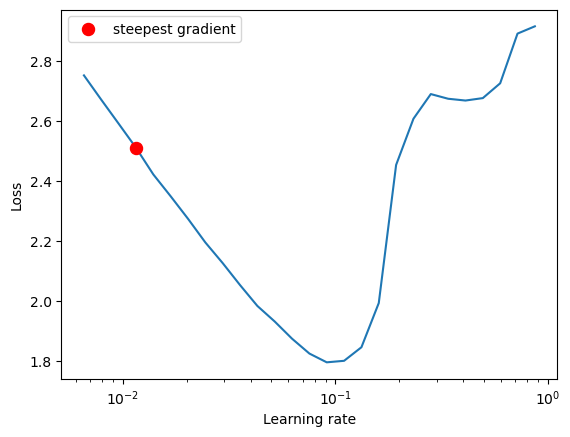

In [13]:
from lr_finder import LRFinder

criterion = nn.NLLLoss(ignore_index=IGNORE_LABEL)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01, betas=(0.9, 0.99))
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataset._train_loader, end_lr=10, num_iter=50)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

# DeepSetAttention lr_range = [0.001, 0.03]
# MVFusion_small_6views     = []

In [55]:
WD = 0.01

MAX_LR = 0.03
min_lr = 0.001

EPOCHS = 10
# STEPS_PER_EPOCH = len(dataset._train_loader)
STEPS_PER_EPOCH = 34
print(STEPS_PER_EPOCH)

DIV_FACTOR = MAX_LR / min_lr

print(DIV_FACTOR)

FEAT_INDICES = [0, 1, 2, 3, 4, 5, 6, 7, 8] #9 # choose max 9

# Create models and load state_dicts    
loss_func = nn.NLLLoss(ignore_index=IGNORE_LABEL)
# model = Linear(feat_indices=FEAT_INDICES, loss_func=loss_func, num_views=cfg.data.n_views, num_classes=dataset.num_classes)
# model = model.cuda()

# print(f"Creating model: {cfg.model_name}")
# model = instantiate_model(cfg, dataset)
# # # Load the checkpoint and recover the 'best_miou' model weights
# # checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
# # model.load_state_dict_with_same_shape(checkpoint['models']['best_miou'], strict=False)
# # Prepare the model for training
# model = model.cuda()
# print('Model loaded')


optim = torch.optim.AdamW(model.parameters(), lr=min_lr, weight_decay=WD, betas=(0.95, 0.99))
# optim = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=MAX_LR, div_factor=DIV_FACTOR, 
                                                steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS)


34
30.0


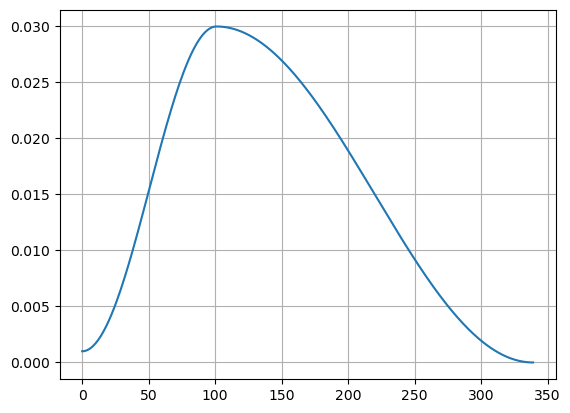

In [57]:
lr_rates = []
for e in range(EPOCHS):
    for i in range(34):
        for param_group in optim.param_groups:
            lr_rates.append(param_group["lr"])

            scheduler.step()
            


plt.plot(lr_rates)
plt.grid()

  0%|          | 0/34 [00:00<?, ?it/s]

training metrics:  {'train_acc': 69.92039190581976, 'train_macc': 33.971989384987744, 'train_miou': 24.43353511923733}


  0%|          | 0/105 [00:01<?, ?it/s]

testing metrics:  {'val_acc': 75.81620682825759, 'val_macc': 33.84659095066881, 'val_miou': 26.870312955750652}


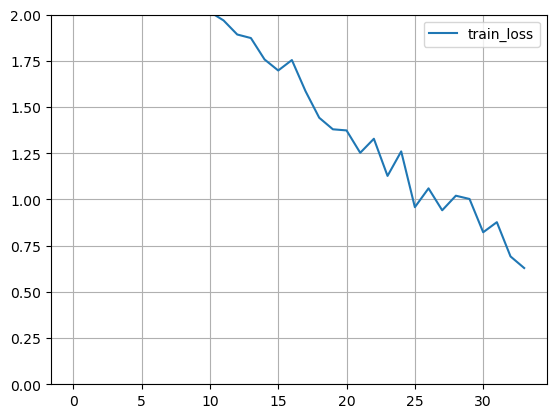

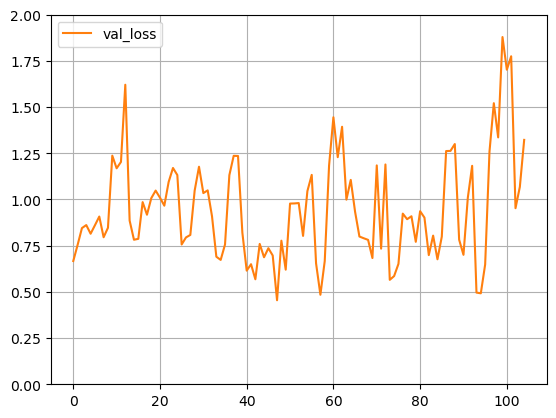

  0%|          | 0/34 [00:00<?, ?it/s]

training metrics:  {'train_acc': 86.56310954411485, 'train_macc': 50.902076089243586, 'train_miou': 42.505644018906885}


  0%|          | 0/105 [00:00<?, ?it/s]

testing metrics:  {'val_acc': 88.8329695444101, 'val_macc': 63.37330543672935, 'val_miou': 52.30075573842632}


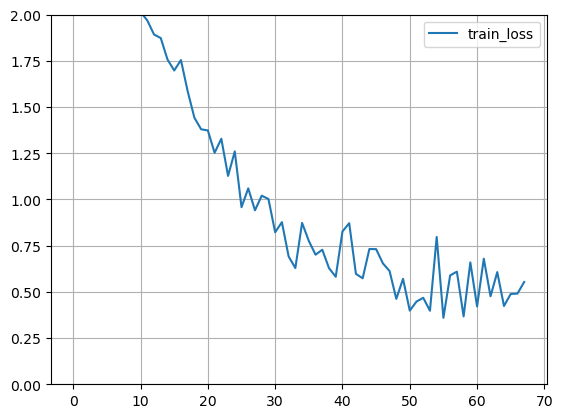

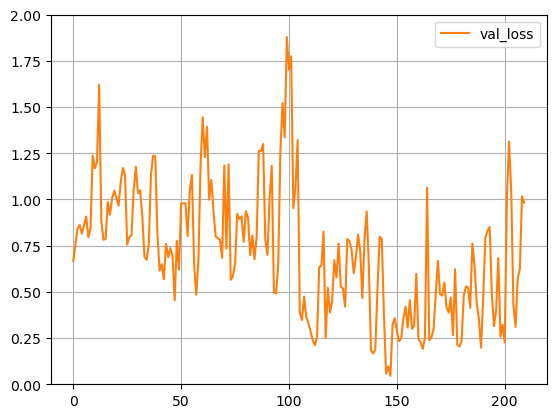

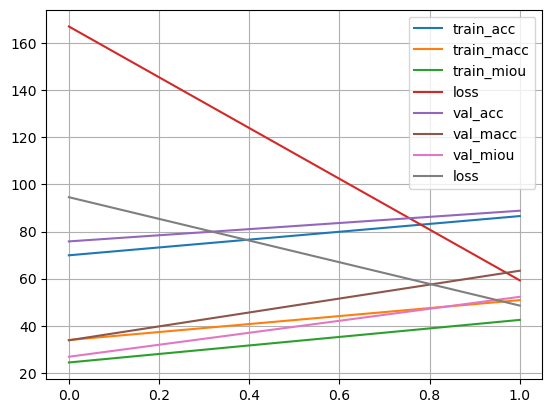

  0%|          | 0/34 [00:00<?, ?it/s]

training metrics:  {'train_acc': 89.011883081284, 'train_macc': 68.01226931913844, 'train_miou': 58.114586535925206}


  0%|          | 0/105 [00:00<?, ?it/s]

testing metrics:  {'val_acc': 90.48170038972057, 'val_macc': 75.99940113877113, 'val_miou': 62.398094942991136}


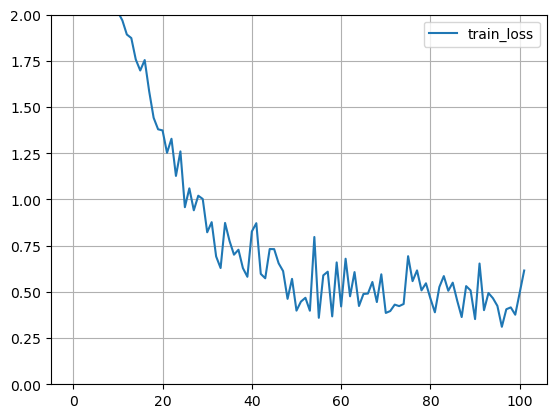

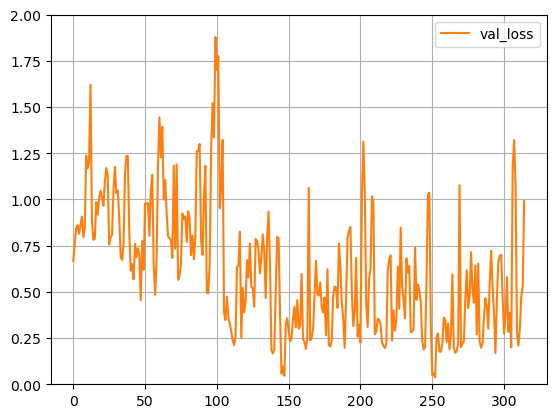

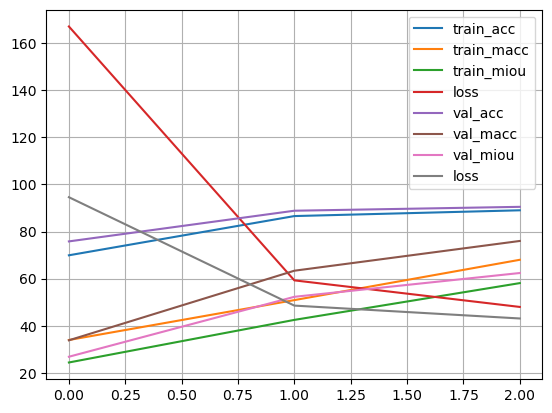

  0%|          | 0/34 [00:00<?, ?it/s]

training metrics:  {'train_acc': 90.19897188072528, 'train_macc': 78.09476964067346, 'train_miou': 67.91503045732432}


  0%|          | 0/105 [00:00<?, ?it/s]

testing metrics:  {'val_acc': 90.873253777519, 'val_macc': 85.12847900503601, 'val_miou': 73.3147814268649}


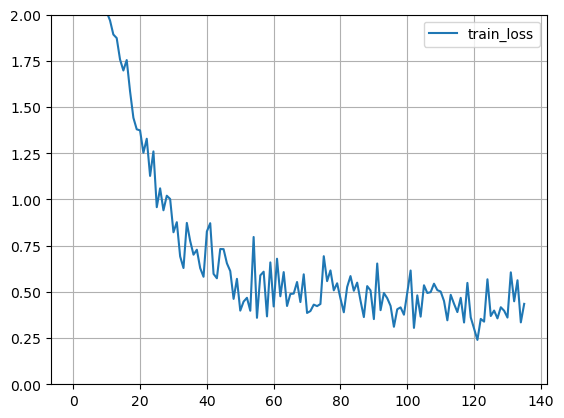

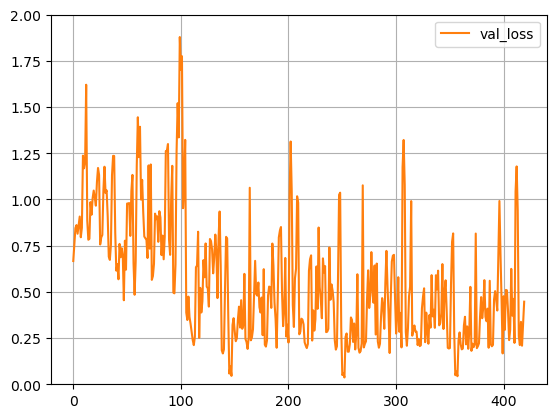

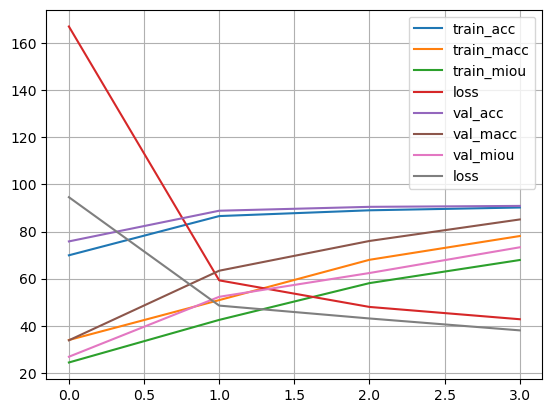

  0%|          | 0/34 [00:00<?, ?it/s]

training metrics:  {'train_acc': 90.99109545213524, 'train_macc': 82.99960231371043, 'train_miou': 73.39082220971406}


  0%|          | 0/105 [00:00<?, ?it/s]

testing metrics:  {'val_acc': 91.12059963481933, 'val_macc': 80.30454470533537, 'val_miou': 67.27601963873039}


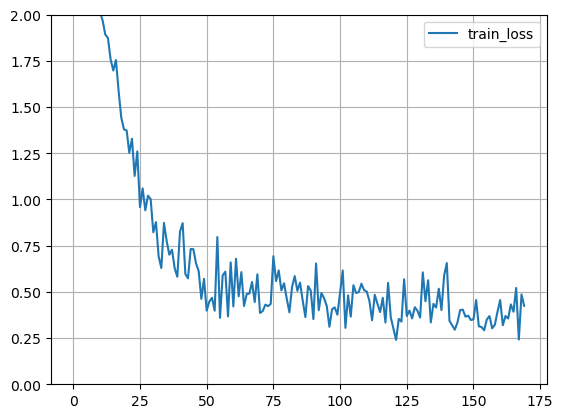

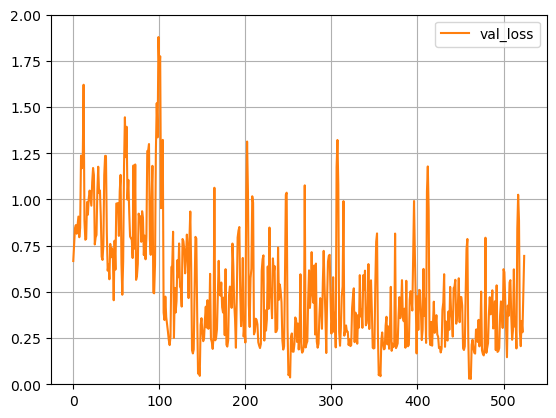

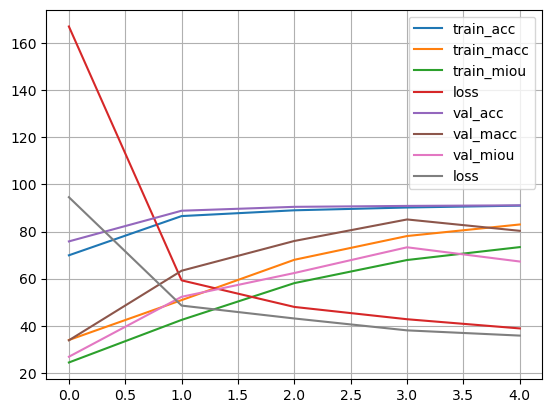

  0%|          | 0/34 [00:00<?, ?it/s]

training metrics:  {'train_acc': 91.30446401677138, 'train_macc': 83.76832636310034, 'train_miou': 74.53168855690949}


  0%|          | 0/105 [00:00<?, ?it/s]

testing metrics:  {'val_acc': 91.42895710578608, 'val_macc': 86.32258112581874, 'val_miou': 74.30810542438915}


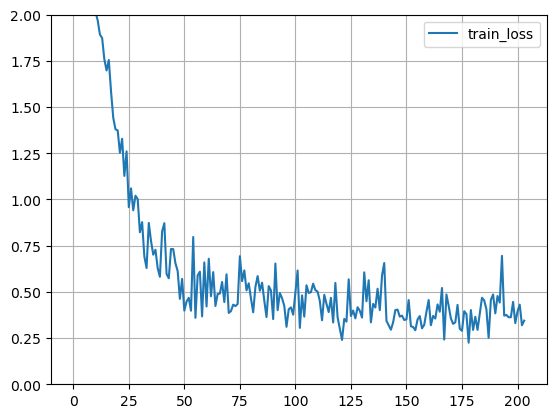

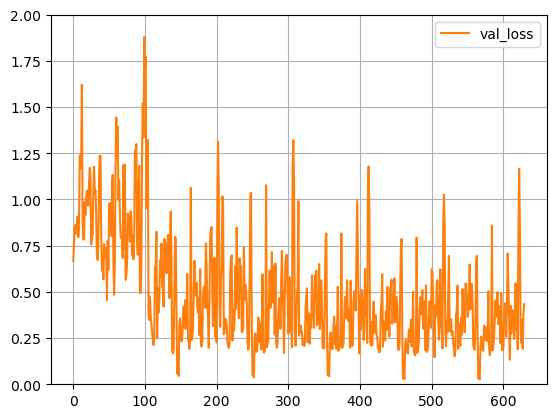

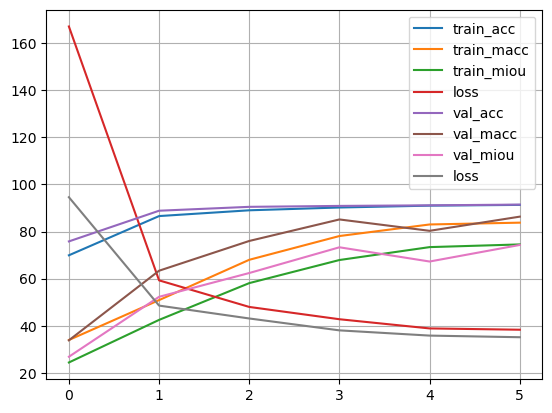

  0%|          | 0/34 [00:00<?, ?it/s]

training metrics:  {'train_acc': 91.44450110913306, 'train_macc': 83.87361304455949, 'train_miou': 75.09882094590277}


  0%|          | 0/105 [00:00<?, ?it/s]

testing metrics:  {'val_acc': 91.72916625364216, 'val_macc': 85.84737920377712, 'val_miou': 74.6771208383855}


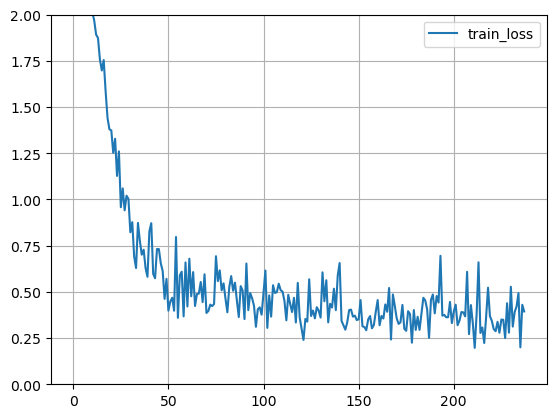

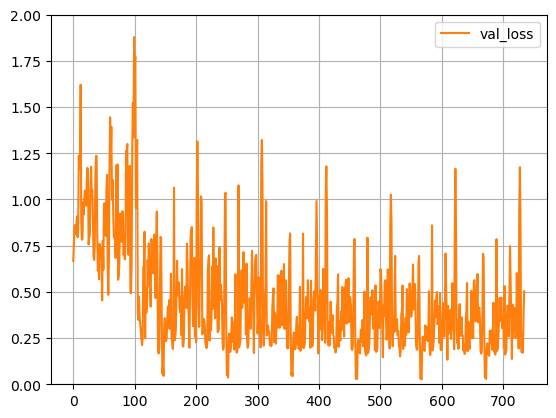

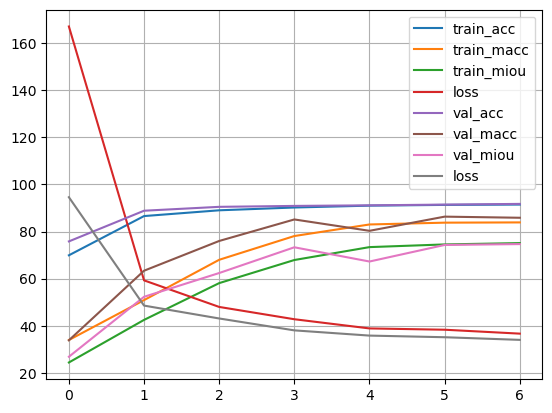

  0%|          | 0/34 [00:00<?, ?it/s]

training metrics:  {'train_acc': 91.55301625196621, 'train_macc': 84.56373342371123, 'train_miou': 75.61060143742279}


  0%|          | 0/105 [00:00<?, ?it/s]

testing metrics:  {'val_acc': 91.51082047641235, 'val_macc': 85.91941551964109, 'val_miou': 74.35286885178891}


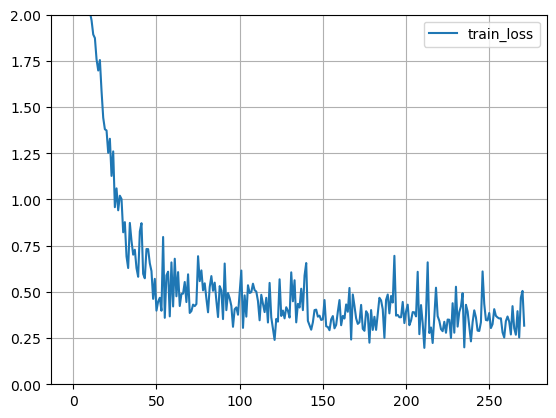

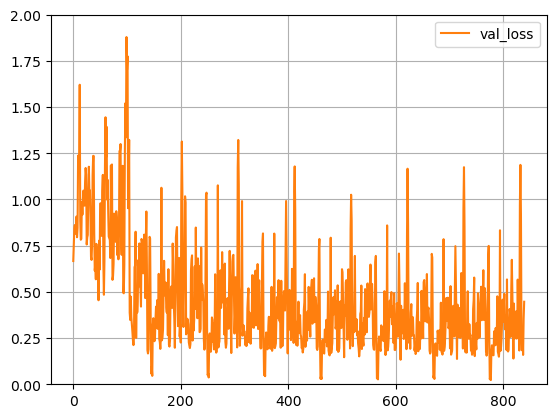

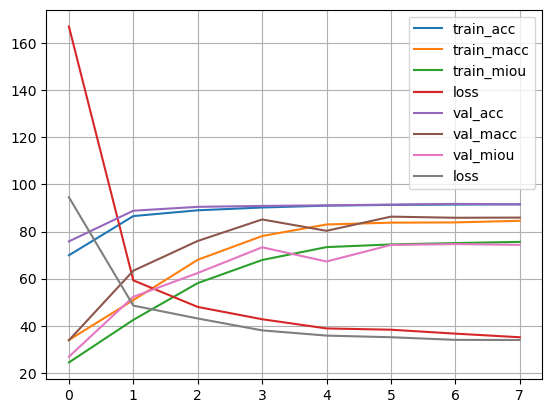

  0%|          | 0/34 [00:00<?, ?it/s]

training metrics:  {'train_acc': 91.70024550805364, 'train_macc': 84.324911486419, 'train_miou': 75.55495975671438}


  0%|          | 0/105 [00:00<?, ?it/s]

testing metrics:  {'val_acc': 91.60504023103695, 'val_macc': 85.97919592391567, 'val_miou': 74.51578889364396}


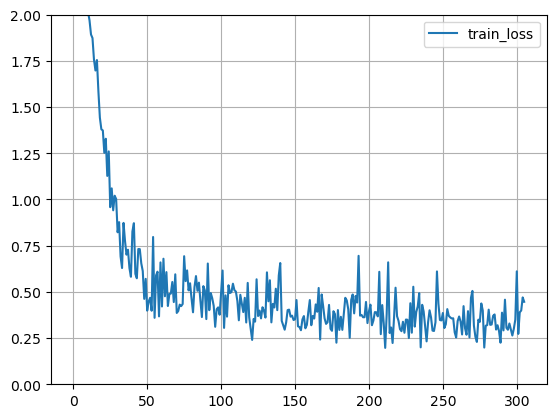

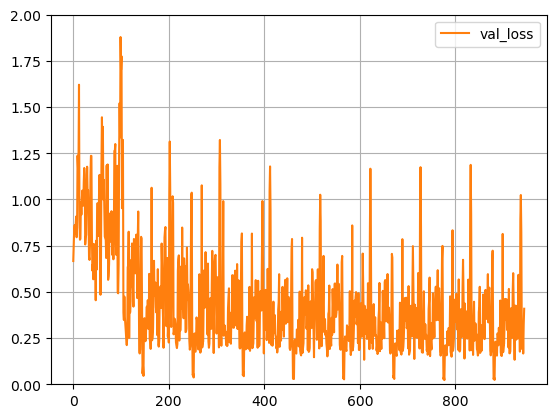

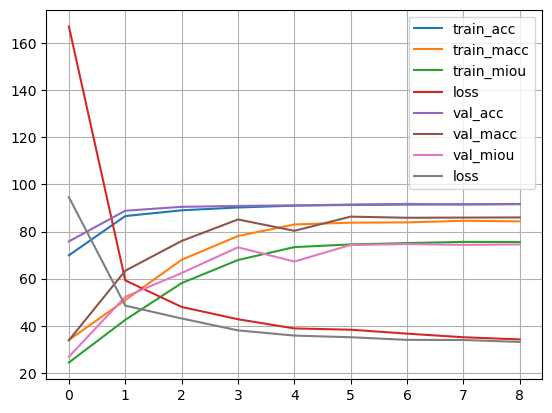

Number of epochs without validation improvement:  3
Best mIoU epoch:  7
Stopping training early due to prevent overfitting


In [10]:
class ModelEvaluator():
    def __init__(self, model, optim, scheduler, dataset, early_stopping=True, patience=3):
        self.model = model
        self.optim = optim
        self.scheduler = scheduler
        self.dataset = dataset
        self.early_stopping = early_stopping
        self.patience = patience
        
        self.train_tracker = ScannetSegmentationTracker(dataset, 'train', False, False, ignore_label=IGNORE_LABEL)
        self.train_tracker_baseline = ScannetSegmentationTracker(dataset, 'train', False, False, ignore_label=IGNORE_LABEL)
        self.test_tracker = ScannetSegmentationTracker(dataset, 'val', False, False, ignore_label=IGNORE_LABEL) 
        self.test_tracker_baseline = ScannetSegmentationTracker(dataset, 'val', False, False, ignore_label=IGNORE_LABEL) 

        if hasattr(self.dataset, '_train_dataloader'):
            del  self.dataset._train_dataloader
        if hasattr(self.dataset, '_val_dataloader'):
            del self.dataset._val_dataloader
        
        # Create train and validation loader
        self.dataset.create_dataloaders(
            model,
            BATCH_SIZE,  # train bs
            True,  # shuffle
            17,
            False,
            train_only=False,
            val_only=False,
            test_batch_size=1
        )    
                
    def plot_losses(self, losses, stage='train'):   
        c = 'tab:blue' if stage == 'train' else 'tab:orange'
        plt.plot(losses, label=f'{stage}_loss', color=c)
        ax = plt.gca()
        ax.set_ylim([0.0, 2.0])
        plt.legend()
        plt.grid()
        plt.show()   
        
    def plot_metrics(self, train_data, test_data):
        for k, v in train_data.items():
            plt.plot(v, label=k)
            
        for k, v in test_data.items():
            plt.plot(v, label=k)
            
        ax = plt.gca()
        ax.set_ylim([0, 100])
        plt.legend()
        plt.grid()
        plt.show()    
        
        print(train_data)
        print(test_data)
        
    def train(self, epochs):
        train_losses = []
        test_losses = []
        train_metrics = defaultdict(lambda: [])
        test_metrics = defaultdict(lambda: [])
        
        best_mIoU = 0.0
        best_mIoU_epoch = 0
        epoch_no_change = 0
        
        for epoch in range(1, epochs+1):
            train_statistics = self.train_one_epoch(epoch)
            train_out = self.train_tracker.get_metrics()
            print("training metrics: ", train_out)
            
            test_statistics = self.test_one_epoch(epoch)
            test_out = self.test_tracker.get_metrics()
            print("testing metrics: ", test_out)


                

            train_losses.extend(train_statistics)
            test_losses.extend(test_statistics)
            
            self.plot_losses(train_losses, stage='train')
            self.plot_losses(test_losses, stage='val')
            
            # Training/testing metrics
            
            for k, v in train_out.items():
                train_metrics[k].append(v)
            for k, v in test_out.items():
                test_metrics[k].append(v)

            train_metrics['loss'] = np.array(train_losses).reshape(epoch, -1).mean(axis=1) * 100
            test_metrics['loss'] = np.array(test_losses).reshape(epoch, -1).mean(axis=1) * 100
            
            if epoch > 1:
                self.plot_metrics(train_metrics, test_metrics)
                
            if self.early_stopping:
                if test_out['val_miou'] < best_mIoU:
                    epoch_no_change += 1
                else:
                    best_mIoU = test_out['val_miou']
                    best_mIoU_epoch = epoch
                    epoch_no_change = 0
                if epoch_no_change >= self.patience:
                    print("Number of epochs without validation improvement: ", epoch_no_change)
                    print(f"Best epoch: {best_mIoU_epoch} = {best_mIoU}")
                    print("Stopping training early due to prevent overfitting")
                    break
                    
            
        
    def train_one_epoch(self, epoch):
        self.model.train()
        self.train_tracker.reset('train')

        losses = []
        with Ctq(self.dataset._train_loader) as loader:
            for batch in loader:
                
                self.optim.zero_grad()
                
                self.model.set_input(batch, self.model.device)
                self.model.forward(epoch=epoch)
                
                self.model.backward()
                self.optim.step()
                self.scheduler.step()
                
                losses.append(self.model.loss_seg.item())

                # Train score
                pred = self.model.output.detach().cpu().argmax(1)
                self.train_tracker.track(gt_labels=self.model.input.y, pred_labels=pred, model=None)
                
        return losses
            
    def test_one_epoch(self, epoch):
        self.model.eval()
        self.test_tracker.reset('val')
        
        losses = []
        with Ctq(self.dataset._val_loader) as loader:
            for batch in loader:
                    
                with torch.no_grad():
                    self.model.set_input(batch, self.model.device)
                    self.model.forward(epoch=epoch)
                losses.append(self.model.loss_seg.item())
                
                pred = self.model.output.detach().cpu().argmax(1)
                self.test_tracker.track(gt_labels=self.model.input.y, pred_labels=pred, model=None)
        return losses
    
evaluator = ModelEvaluator(model, optim, scheduler, dataset, early_stopping=True, patience=5)
evaluator.train(epochs=EPOCHS)


In [22]:
from collections import defaultdict

def plot_label_distribution(data, preds):
        
    if isinstance(preds, list):
        preds = torch.vstack(preds)
        
    mask_ignore = data.y != -1
    pred_labels = preds[:, mask_ignore]
    gt_labels = data.y[mask_ignore]
        

    # Defining the dict
    d = defaultdict(lambda: np.zeros((1 + pred_labels.shape[0])))
            
    # Add gt values
    unique = gt_labels.unique(return_counts=True)        
    for k, v in list(zip(*unique)):
        d[k.item()][0] = v.item()
            
    # Add predicted labels of each epoch
    for i, labels in enumerate(pred_labels):
        unique = labels.unique(return_counts=True)        
        for k, v in list(zip(*unique)):
            d[k.item()][i+1] = v.item()   # idx 0 = gt, idx 1 = 1st epoch
            
    values = np.vstack(list(d.values()))
    
    # Normalize values
    for i in range(values.shape[1]):
        values[:, i] = values[:, i] / values[:, i].sum() * 100

#     values = values / values.sum() * 100
    
    values_dict = {}
    values_dict["Ground-truth"] = values[:, 0]
    for i in range(1, values.shape[1], 1):        
        values_dict[f"Epoch {i}"] = values[:, i]

    class_indices = list(d.keys())

    x = np.arange(len(class_indices))  # the label locations
    width = 0.125  # the width of the bars
    multiplier = -2 * (values.shape[1] + 1) * width # (7+x) * 0.125 = 2.0

    fig, ax = plt.subplots(figsize=(19, 10), constrained_layout=True)

    for attribute, measurement in values_dict.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3, labels=['%.1f' % m for m in measurement], fontsize=6)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('% of total')
    ax.set_title(f'Label distribution')
    ax.legend(loc='upper right')

    # ax.set_ylim(0, 250)
#     ax.set_yscale('log')

    locs, labels = plt.xticks()  # Get the current locations and labels.
    plt.xticks(x + width, np.array(CLASS_NAMES)[class_indices],
           rotation=45)  # Set text labels and properties.

    plt.show()

### Model behavior analysis

In [10]:
# @torch.no_grad()
# def init_weights(m):
#     print(m)
#     if type(m) == nn.Linear:
#         print(m.weight)
#         m.weight.fill_(1.0)
#         print(m.weight)

# net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
# net.apply(init_weights)


test_seen_batch = dataset.val_dataset[0]

backbone.transformerfusion.fusion.cls_token
backbone.transformerfusion.fusion.input_layer.weight
backbone.transformerfusion.fusion.transformer_layers.0.attn.in_proj_weight
backbone.transformerfusion.fusion.transformer_layers.0.attn.out_proj.weight
backbone.transformerfusion.fusion.transformer_layers.0.linear.0.weight
backbone.transformerfusion.fusion.transformer_layers.0.linear.3.weight
backbone.transformerfusion.fusion.transformer_layers.1.attn.in_proj_weight
backbone.transformerfusion.fusion.transformer_layers.1.attn.out_proj.weight
backbone.transformerfusion.fusion.transformer_layers.1.linear.0.weight
backbone.transformerfusion.fusion.transformer_layers.1.linear.3.weight
backbone.transformerfusion.fusion.transformer_layers.2.attn.in_proj_weight
backbone.transformerfusion.fusion.transformer_layers.2.attn.out_proj.weight
backbone.transformerfusion.fusion.transformer_layers.2.linear.0.weight
backbone.transformerfusion.fusion.transformer_layers.2.linear.3.weight
backbone.transformerfusi

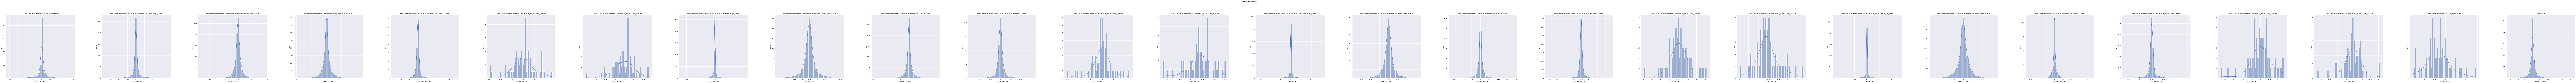

In [12]:
# def const_init(model, c=0.0):
#     for name, param in model.named_parameters():
#         param.data.fill_(c)

# const_init(model, c=0.005)

# def var_init(model, std=0.01):
#     for name, param in model.named_parameters():
#         param.data.normal_(std=std)

# var_init(model, std=0.01)

import math
# def equal_var_init(model):
#     for name, param in model.named_parameters():
#         if name.endswith(".bias"):
#             param.data.fill_(0)
#         else:
#             n = param.shape[-1]
#             param.data.normal_(std=1.0/math.sqrt(n))

# equal_var_init(model)

def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith("bias"):
            param.data.fill_(0)
        else:
            if not 'norm' in name.split(".")[-2]:
                print(name)
                bound = math.sqrt(6)/math.sqrt(param.shape[0]+param.shape[1])
                param.data.uniform_(-bound, bound)

xavier_init(model)

visualize_gradients(model, test_seen_batch)

In [6]:
##############################################################

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*15, 10))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

##############################################################

def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

##############################################################

def visualize_gradients(model, data, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    
    model.set_input(data, device='cuda:0')
    model.forward(epoch=1)
    
    preds = model.output
    loss = F.nll_loss(preds, model.labels, ignore_index=IGNORE_LABEL) # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, data, color="C0", print_variance=False):
    model.eval()

    # Pass one batch through the network, and calculate the gradients for the weights
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(data)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

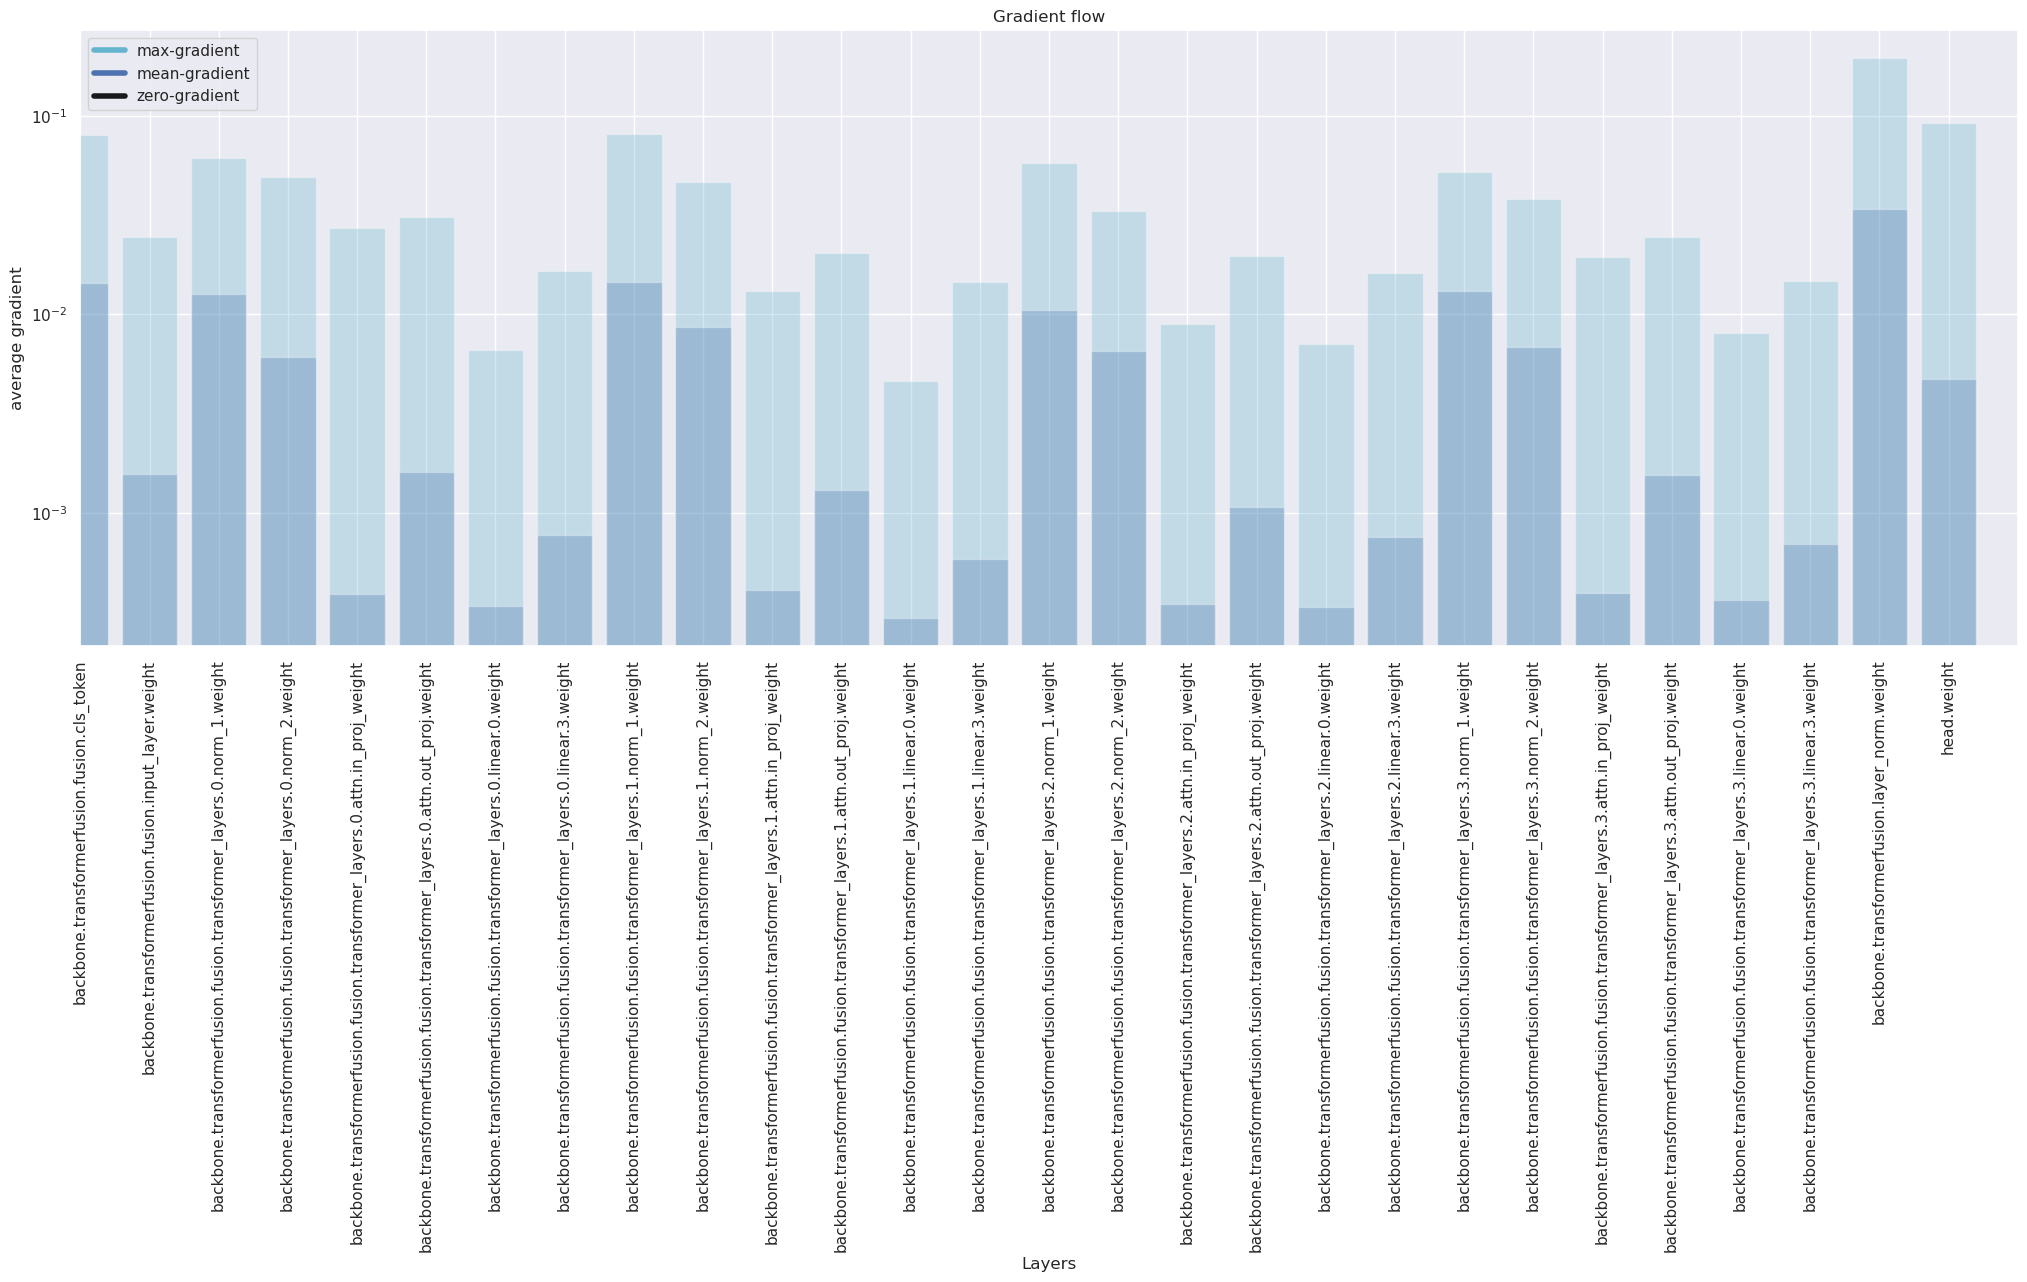

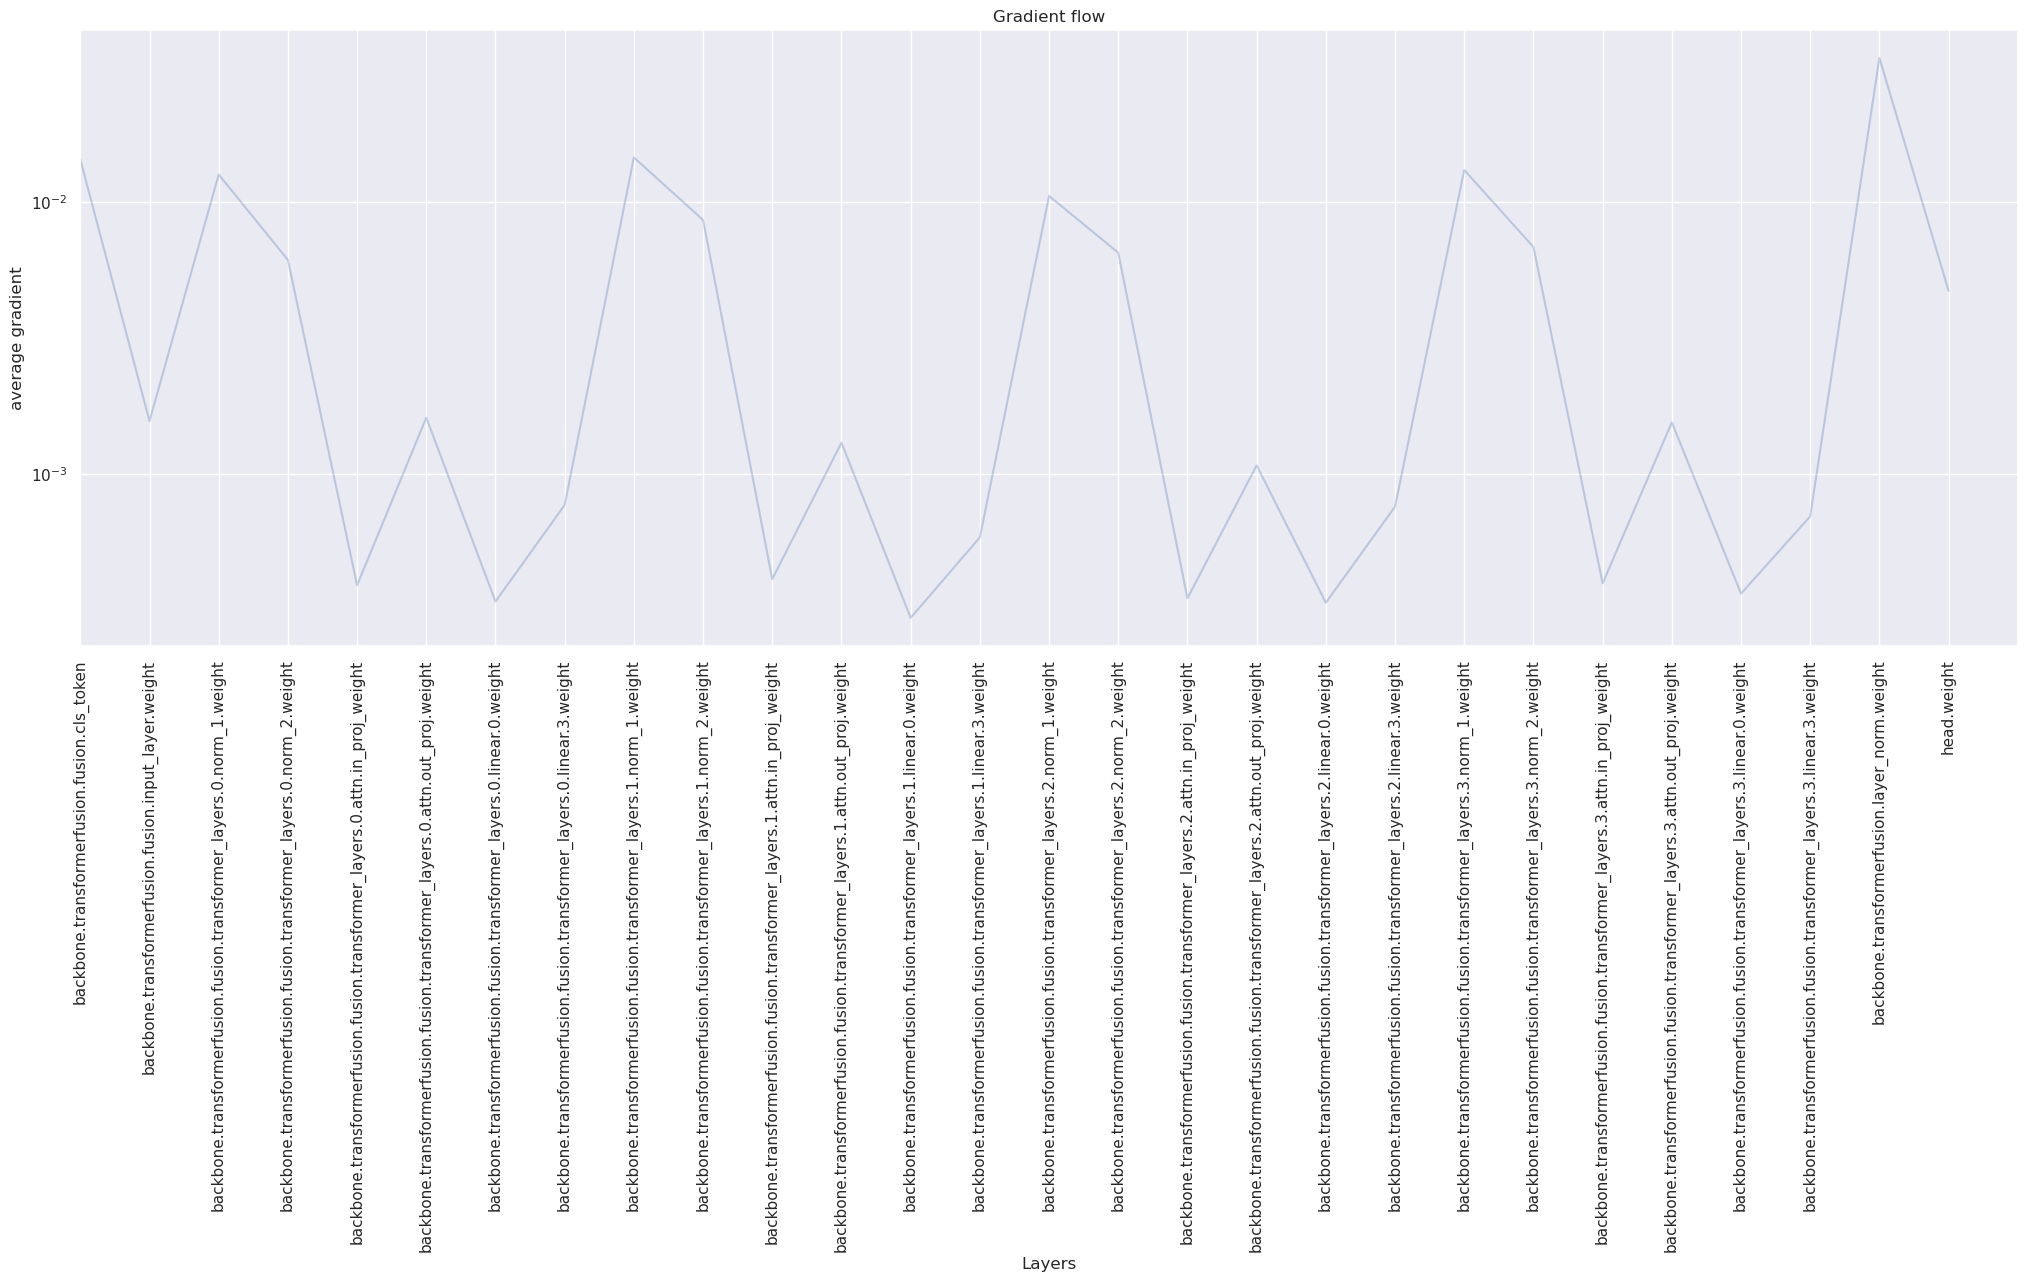

In [74]:
def plot_grad_flow_v2(named_parameters):
    from matplotlib.pyplot import Line2D
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    
    count = 0
    for n, p in named_parameters:
        count += 1
        if count > 33333:
            break
        if(p.requires_grad) and ("bias" not in n) and p.grad is not None:
            layers.append(n)
            ave_grads.append(p.grad.cpu().abs().mean())
            max_grads.append(p.grad.cpu().abs().max())
            
    plt.figure(figsize=(25, 8))
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.3, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.3, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
#     plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.yscale("log")
    plt.show()
    
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.cpu().abs().mean())
    plt.figure(figsize=(25, 8))
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.yscale("log")
    plt.show()
    
    
model.set_input(test_seen_batch, model.device)
model.forward(epoch=1)
model.backward()
    
plot_grad_flow_v2(model.named_parameters())

plot_grad_flow(model.named_parameters())


In [5]:
colormap = plt.cm.tab10.colors   # Qualitative colormap

def read_scores(file):
    with open(f'/home/fsun/DeepViewAgg/job_logs/{file}') as f:
        lines = f.readlines()

        pattern = 'train_miou ='
        matching_lines = [line for line in lines if pattern in line]
        train_scores = [float(m.split()[-1]) / 100 for m in matching_lines]
        
        pattern = 'train_loss_seg ='
        matching_lines = [line for line in lines if pattern in line]
        train_losses = [float(m.split()[-1]) for m in matching_lines]
        
        pattern = 'train_loss_cross_entropy ='
        matching_lines = [line for line in lines if pattern in line]
        train_loss_cross_entropy = [float(m.split()[-1]) for m in matching_lines]
  
        pattern = 'val_miou ='
        matching_lines = [line for line in lines if pattern in line]
        val_scores = [float(m.split()[-1]) / 100 for m in matching_lines]
        
        pattern = 'val_loss_seg ='
        matching_lines = [line for line in lines if pattern in line]
        val_losses = [float(m.split()[-1]) for m in matching_lines]
        
        pattern = 'val_loss_cross_entropy ='
        matching_lines = [line for line in lines if pattern in line]
        val_loss_cross_entropy = [float(m.split()[-1]) for m in matching_lines]
        
    return {'train_scores': train_scores,
            'train_losses': train_losses,
            'val_scores': val_scores,
            'val_losses': val_losses,
            'train_loss_cross_entropy': train_loss_cross_entropy,
            'val_loss_cross_entropy': val_loss_cross_entropy,
    }

def plot_graph(data, log_scale=False, title='Model training statistics'):
    plt.figure(figsize=(10,6))
    train_scores = data['train_scores']
    train_losses = data['train_losses']
    val_scores = data['val_scores']
    val_losses = data['val_losses']

    plt.plot(range(len(train_scores)), train_scores, color=colormap[0], label=f'Train score')
    plt.plot(range(len(val_scores)), val_scores, color=colormap[1], label=f'Val score')

    plt.plot(range(len(train_losses)), train_losses, color=colormap[2], label=f'Train loss')
    plt.plot(range(len(val_losses)), val_losses, color=colormap[3], label=f'Val loss')

    # Plot generalization error
    val_range = range(len(val_losses))

    gen_error = np.array(val_losses) - np.array(train_losses)
    plt.plot(val_range, gen_error, color=colormap[4], label=f'Generalization error')

    plt.legend()
    plt.title(title)
    plt.xlabel('Epochs')
    ax = plt.gca()
    if log_scale:
        ax.set_yscale('log')
    # ax.set_xlim([xmin, xmax])
    ax.set_ylim([0.0, 0.9])
    plt.grid()

    plt.show()


def plot_barchart(x_range, values, title, ylim=None):
    objects = list(x_range)
    y_pos = np.arange(len(objects))
    performance = values

    plt.figure(figsize=(10,6))
    plt.grid()

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('')
    plt.title(title)
    
    if isinstance(ylim, list):
        ax = plt.gca()
        ax.set_ylim(ylim)

    plt.show()

# Read and plot previous training curves

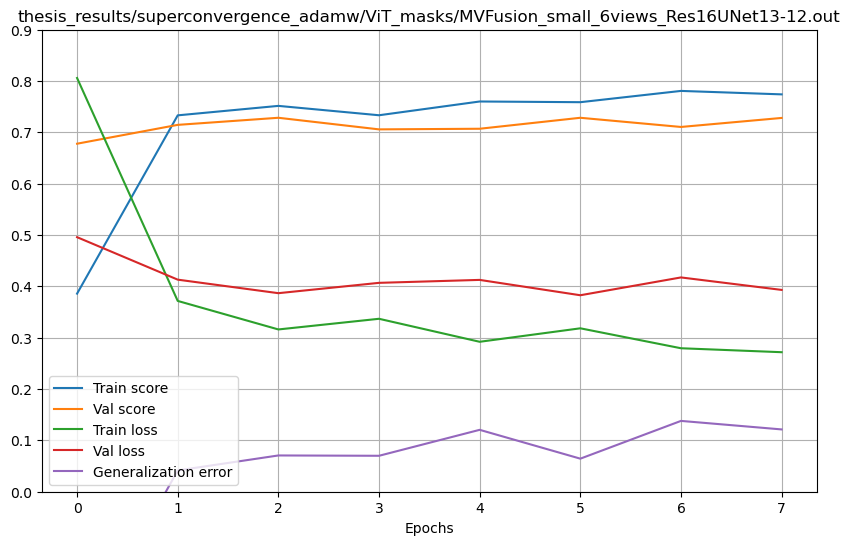

Max val score:  0.7284708763238072


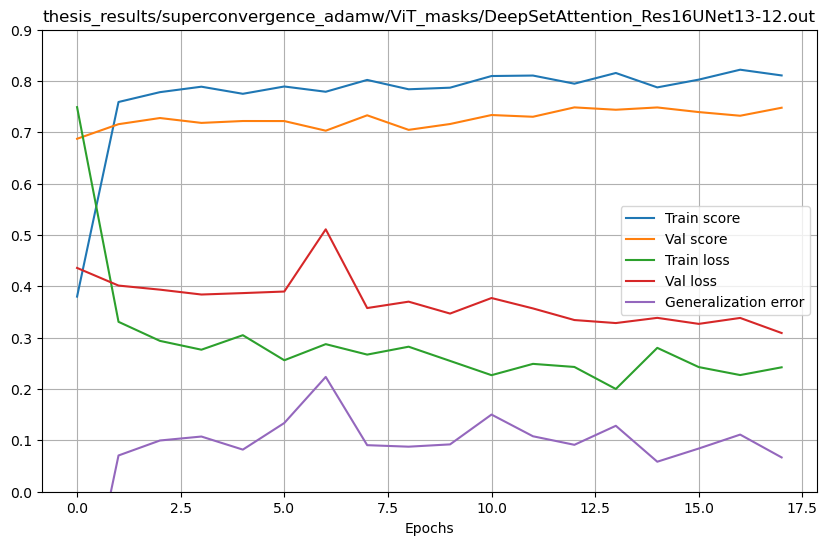

Max val score:  0.7487066220151761


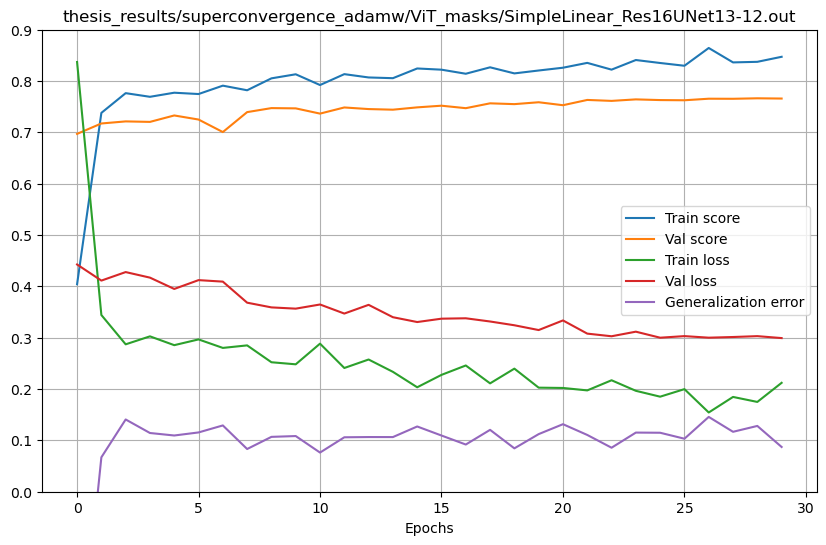

Max val score:  0.7664004099416357


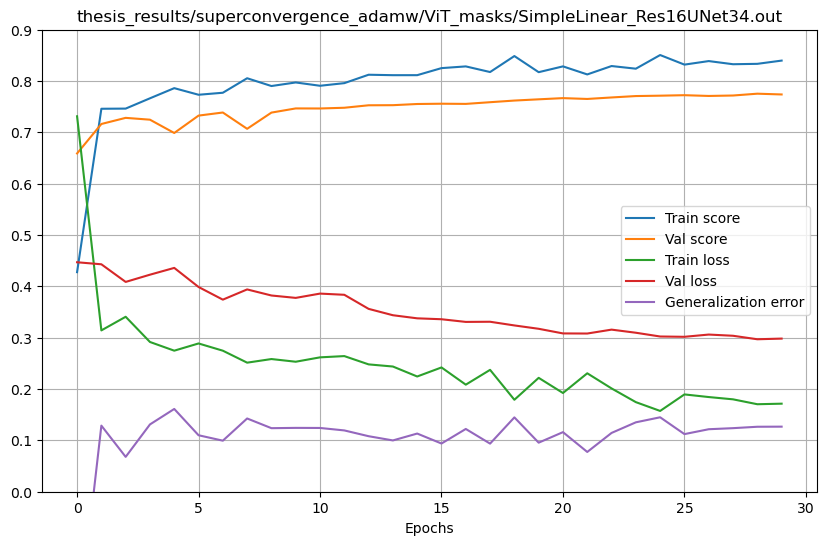

Max val score:  0.7753859460071905


In [6]:
names = [
#     'thesis_results/ViT_masks/DeepSet_bs6_lr0.06.out',
#     'thesis_results/ViT_masks/Deepset_3D.out',
#     'thesis_results/ViT_masks/MVFusion_small_6views_hotfixed.out',
#     'thesis_results/ViT_masks/MVFusion_3D_small_6views.out', # 5
#     'thesis_results/ViT_masks/MVFusion_3D_small_6views_hotfixed.out', # 6
#     'thesis_results/superconvergence_adamw/ViT_masks/DeepSetAttention.out',
#     'thesis_results/superconvergence_adamw/ViT_masks/MVFusion_small_6views.out',
    
    'thesis_results/superconvergence_adamw/ViT_masks/MVFusion_small_6views_Res16UNet13-12.out',
    'thesis_results/superconvergence_adamw/ViT_masks/DeepSetAttention_Res16UNet13-12.out',
    'thesis_results/superconvergence_adamw/ViT_masks/SimpleLinear_Res16UNet13-12.out',
    'thesis_results/superconvergence_adamw/ViT_masks/SimpleLinear_Res16UNet34.out',
    
#     'thesis_results/superconvergence_adamw/ViT_masks/DeepSetAttention_15epochs.out',
#     'thesis_results/superconvergence_adamw/ViT_masks/MVFusion_small_6views_15epochs.out',
#     'thesis_results/superconvergence_adamw/ViT_masks/DeepSetAttention_Res16UNet13-12_split_lr_30_epochs.out',
#     'thesis_results/superconvergence_adamw/ViT_masks/MVFusion_small_6views_Res16UNet13-12_split_lr_30_epochs.out',
    
]

for i in range(len(names)):
#     try:
    data = read_scores(file=names[i])
    if len(data['val_scores']) > len(data['val_losses']):
        data['val_scores'] = data['val_scores'][:-4]

    plot_graph(data, log_scale=False, title=names[i])

    # Generalization error
#     val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
#     gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
    # plot_barchart(val_range, gen_error, 'Generalization error')
#         plot_barchart(val_range, data['val_scores'], names[i], ylim=[0.7, 0.8])
    print("Max val score: ", max(data['val_scores']))
#     except:
#         print(len(data['train_scores']))
#         print(len(data['train_losses']))
#         print(len(data['val_scores']))
#         print(len(data['val_losses']))
#         print(data['val_scores'])
#         print(f"{names[i]} is broken!")
#         continue


# # MVFusion_3D_small default 
# data = read_scores(file='thesis_results/ViT_masks/DeepSet_bs6_lr0.06.out')
# plot_graph(data, log_scale=False)

# # Generalization error
# val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
# gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
# # plot_barchart(val_range, gen_error, 'Generalization error')
# plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])
# print("Max val score: ", max(data['val_scores']))

In [2]:
colormap = plt.cm.tab10.colors   # Qualitative colormap

def read_scores(file):
    with open(f'/home/fsun/DeepViewAgg/job_logs/{file}') as f:
        lines = f.readlines()

        pattern = 'train_miou ='
        matching_lines = [line for line in lines if pattern in line]
        train_scores = [float(m.split()[-1]) / 100 for m in matching_lines]
        
        pattern = 'train_loss_seg ='
        matching_lines = [line for line in lines if pattern in line]
        train_losses = [float(m.split()[-1]) for m in matching_lines]
        
        pattern = 'train_loss_cross_entropy ='
        matching_lines = [line for line in lines if pattern in line]
        train_loss_cross_entropy = [float(m.split()[-1]) for m in matching_lines]
  
        pattern = 'val_miou ='
        matching_lines = [line for line in lines if pattern in line]
        val_scores = [float(m.split()[-1]) / 100 for m in matching_lines]
        
        pattern = 'val_loss_seg ='
        matching_lines = [line for line in lines if pattern in line]
        val_losses = [float(m.split()[-1]) for m in matching_lines]
        
        pattern = 'val_loss_cross_entropy ='
        matching_lines = [line for line in lines if pattern in line]
        val_loss_cross_entropy = [float(m.split()[-1]) for m in matching_lines]
        
        # Adjust length of lists
        max_len = len(val_scores * 5)
        train_scores = train_scores[:max_len]
        train_losses = train_losses[:max_len]    
    return {'train_scores': train_scores,
            'train_losses': train_losses,
            'val_scores': val_scores,
            'val_losses': val_losses,
            'train_loss_cross_entropy': train_loss_cross_entropy,
            'val_loss_cross_entropy': val_loss_cross_entropy,
    }

def plot_graph(data, log_scale=False, title='Model training statistics'):
    plt.figure(figsize=(10,6))
    train_scores = data['train_scores']
    train_losses = data['train_losses']
    val_scores = data['val_scores']
    val_losses = data['val_losses']

    plt.plot(range(len(train_scores)), train_scores, color=colormap[0], label=f'Train score')
    plt.plot(range(4, len(train_scores) - len(train_scores) % 5, 5), val_scores, color=colormap[1], label=f'Val score')

    plt.plot(range(len(train_losses)), train_losses, color=colormap[2], label=f'Train loss')
    plt.plot(range(4, len(train_losses) - len(train_losses) % 5, 5), val_losses, color=colormap[3], label=f'Val loss')

    # Plot generalization error
    val_range = range(4, len(train_losses) - len(train_losses) % 5, 5)

    gen_error = np.array(val_losses) - np.array([train_losses[i] for i in val_range])
    plt.plot(val_range, gen_error, color=colormap[4], label=f'Generalization error')

    plt.legend()
    plt.title(title)
    plt.xlabel('Epochs')
    ax = plt.gca()
    if log_scale:
        ax.set_yscale('log')
    # ax.set_xlim([xmin, xmax])
    ax.set_ylim([0.0, 0.9])
    plt.grid()

    plt.show()


def plot_barchart(x_range, values, title, ylim=None):
    objects = list(x_range)
    y_pos = np.arange(len(objects))
    performance = values

    plt.figure(figsize=(10,6))
    plt.grid()

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('')
    plt.title(title)
    
    if isinstance(ylim, list):
        ax = plt.gca()
        ax.set_ylim(ylim)

    plt.show()

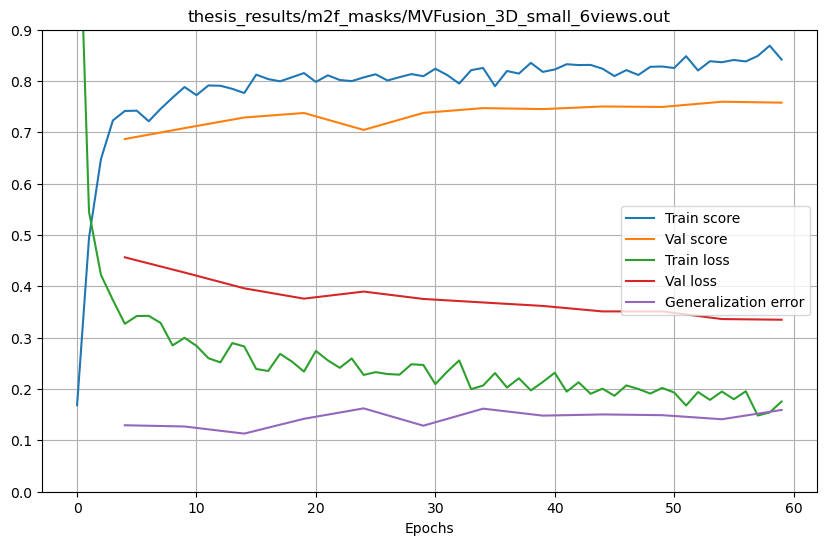

Max val score:  0.7597403983681236


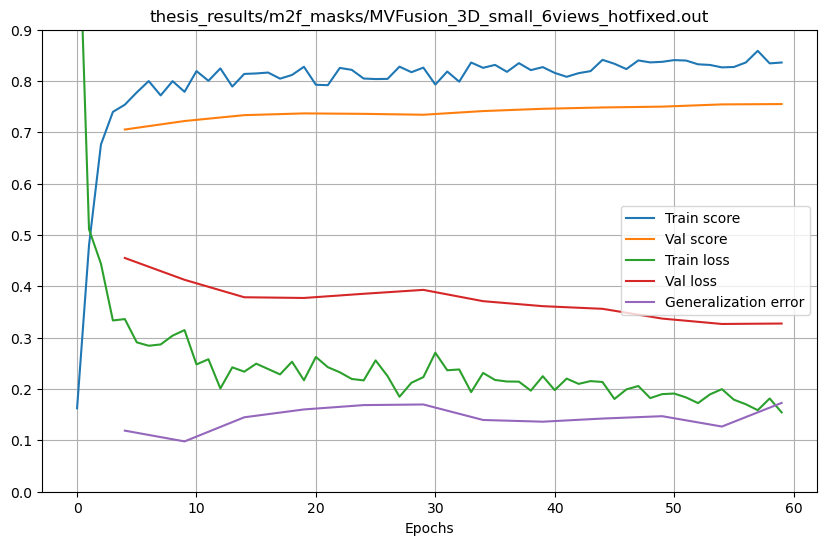

Max val score:  0.7551801523913619


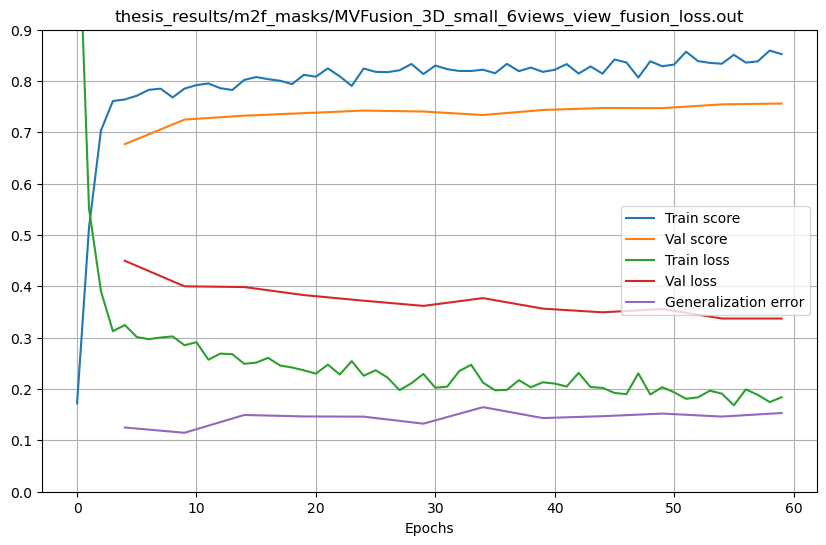

Max val score:  0.7562273123902039


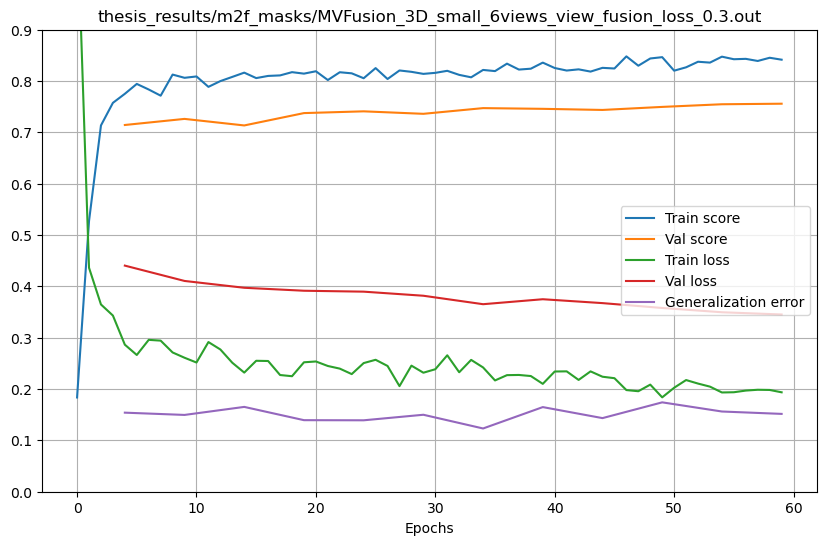

Max val score:  0.7558693485199994


In [3]:
names = [
#     'thesis_results/ViT_masks/DeepSet_bs6_lr0.06.out',
#     'thesis_results/ViT_masks/Deepset_3D.out',
#     'thesis_results/ViT_masks/MVFusion_small_6views_hotfixed.out',
#     'thesis_results/m2f_masks/MVFusion_small_6views_hotfixed.out', # 0
#     'thesis_results/m2f_masks/MVFusion_small_6views_hotfixed_onecyclelr.out',

    'thesis_results/m2f_masks/MVFusion_3D_small_6views.out',       # 1
    'thesis_results/m2f_masks/MVFusion_3D_small_6views_hotfixed.out', # 2
    'thesis_results/m2f_masks/MVFusion_3D_small_6views_view_fusion_loss.out', # 3
    'thesis_results/m2f_masks/MVFusion_3D_small_6views_view_fusion_loss_0.3.out', # 4

#     'thesis_results/ViT_masks/MVFusion_3D_small_6views.out', # 5
#     'thesis_results/ViT_masks/MVFusion_3D_small_6views_hotfixed.out', # 6
]

for i in range(len(names)):
    try:
        data = read_scores(file=names[i])
        if len(data['val_scores']) > len(data['val_losses']):
            data['val_scores'] = data['val_scores'][:-4]
        
        plot_graph(data, log_scale=False, title=names[i])

        # Generalization error
        val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
        gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
        # plot_barchart(val_range, gen_error, 'Generalization error')
#         plot_barchart(val_range, data['val_scores'], names[i], ylim=[0.7, 0.8])
        print("Max val score: ", max(data['val_scores']))
    except:
        print(len(data['train_scores']))
        print(len(data['train_losses']))
        print(len(data['val_scores']))
        print(len(data['val_losses']))
        print(data['val_scores'])
        print(f"{names[i]} is broken!")
        continue


# # MVFusion_3D_small default 
# data = read_scores(file='thesis_results/ViT_masks/DeepSet_bs6_lr0.06.out')
# plot_graph(data, log_scale=False)

# # Generalization error
# val_range = range(4, len(data['train_losses']) - len(data['train_losses']) % 5, 5)
# gen_error = np.array(data['val_losses']) - np.array([data['train_losses'][i] for i in val_range])
# # plot_barchart(val_range, gen_error, 'Generalization error')
# plot_barchart(val_range, data['val_scores'], 'Validation score', ylim=[0.7, 0.77])
# print("Max val score: ", max(data['val_scores']))